# PF
未完成

In [491]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [492]:
import numpy as np
import matplotlib.pyplot as plt
from l96 import gen_l96, rk4
from loss import loss_rms
from visualize import plot_loss
from pf import ParticleFilter as PF

In [499]:
# Lorenz96の設定
J = 40
F = 8
lorenz = gen_l96(F)

# 同化step
# 時間発展は0.01ごとに行う
dt = 0.05

# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, dt):
    for i in range(int(dt/0.01)):
        x = rk4(lorenz, 0, x, 0.01)
    return x

# 単位行列
I = np.eye(J)

# 観測
H = I

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((J, J))

# 観測誤差共分散, 後で定数倍の変化をさせる.
r = 1.0
R = r*I

# 観測値と真値
end_step = -1 # 開発用
x_true = np.load('../data/x_true.npy')[:end_step]
y = np.load('../data/x_obs.npy')[:end_step]
if not np.isclose(r, 1.0):
    y = x_true + np.random.normal(loc=0, scale=r, size=x_true.shape) # R = r*I

# KFの初期値
seed = 1
np.random.seed(seed)
x_0 = x_true[np.random.randint(len(x_true)-1)]

P_0 = 25*I

In [494]:
# x_0 = x_true[0]
# P_0 = 0.1*I
# (y[0] - H @ x_0) @ R @ (y[0] - H @ x_0)

49.2195742210083

In [508]:
end = 21
pf = PF(M, H, R, x_0, P_0, m=10000, seed=seed)
for y_obs in y[:end]:
    pf.forecast(dt)
    pf.update(y_obs)

x_assim = pf.x

In [509]:
pf.trP

[31.611303359347968,
 31.200985391242156,
 32.21003652912974,
 33.10922054186307,
 33.31401337974246,
 32.95613555895584,
 32.188878849923285,
 31.365538058827692,
 30.540360069454053,
 29.709900605273255,
 28.85888312886165,
 28.152611619879757,
 27.407056891961542,
 26.77372610928761,
 26.188892970074114,
 25.666468091679015,
 25.186835291692535,
 24.77508520048301,
 24.47768352357325,
 24.178778140873245,
 23.96666935262877]

mean: 0.9869
mean: 3.9357


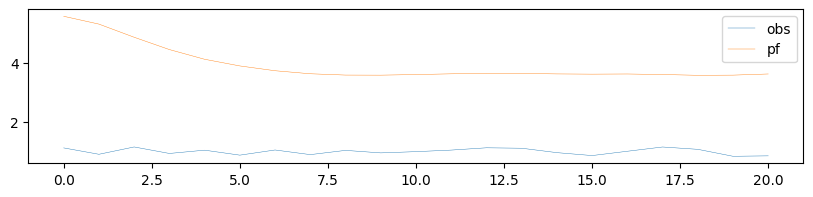

In [511]:
fig, ax = plt.subplots(figsize=(10, 2))
plot_loss(x_true[:end], y[:end], loss_rms, ax=ax, label='obs', lw=0.3)
plot_loss(x_true[:end], x_assim[:end], loss_rms, ax=ax, label='pf', lw=0.3)
ax.legend()
# ax.set_ylim([0, 2])